# Final Challenge - Walkthrough - RDD

**You are required to turn in this completed notebook and a Python's script that runs on the Hadoop cluster.** This notebook is only for developing and testing your code.

We still use the [Safegraph data](https://www.safegraph.com/covid-19-data-consortium) to better understand how NYC response to the COVID-19 pandemic. If you have any doubts about the data, please consult SafeGraph's documentation for [Places Schema](https://docs.safegraph.com/v4.0/docs/places-schema) and [Weekly Pattern](https://docs.safegraph.com/v4.0/docs/weekly-patterns).

## Problem Description

To assess the food access problem in NYC before and during the COVID-19 pandemic, we would like to plot the visit patterns for all food stores (including restaurants, groceries, deli's, etc.) such as the one shown below.

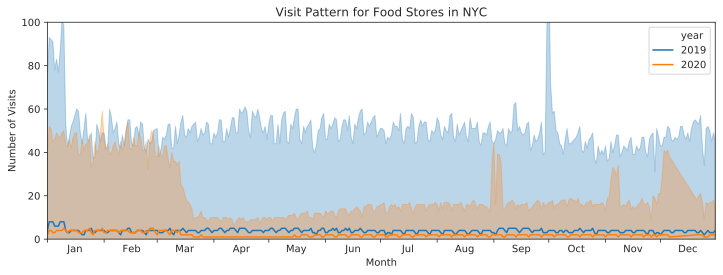

In [ ]:
#@title A visualization of Visit Pattern for all food stores in NYC
#@markdown The solid lines show the median patterns and the transparent areas show the standard deviation across stores for 2019 and 2020.

However, we suspect that the visit patterns may vary across different type of stores. Our hypothesis is that we have changed our shopping behavior during the pandemic. For example, we visit Fast Food and Whole Saler restaurants more often comparing to full service restaurants and typical supermarkets. In particular, we are interested in the following store categories with their **NAICS** codes:

* *Big Box Grocers*: `452210` and `452311`
* *Convenience Stores*: `445120`
* *Drinking Places*: `722410`
* *Full-Service Restaurants*: `722511`
* *Limited-Service Restaurants*: `722513`
* *Pharmacies and Drug Stores*: `446110` and `446191`
* *Snack and Bakeries*: `311811` and `722515`
* *Specialty Food Stores*: `445210`, `445220`, `445230`, `445291`, `445292`, and `445299`
* *Supermarkets (except Convenience Stores)*: `445110`

In [ ]:
#@markdown The plot above was created by the `linePlot()` function (defined later), which takes a Panda's DataFrame consisting of 5 columns as follows.

,year,date,median,low,high
0,2019,2020-01-01,14,0,74
1,2019,2020-01-02,26,0,89
2,2019,2020-01-03,28,0,97
3,2019,2020-01-04,32,0,107
4,2019,2020-01-05,20,0,79


* `year`: column is used for showing the trend line category (orange or blue).
* `date`: denotes the day of the year for each data point, for which we project to to year 2020. We chose 2020 as the base year because it is a leap year and would have all possile dates (i.e. month + day combination). The actual date for the data point would be month and day from `date` combined with the year in `year`.
* `median`: is used to draw the solid line describing the median visit counts across all stores for that date.
* `low`: the lower bound of the "confidence interval". In our plot, it is the `median` minus the standard deviation but will be kept at 0 or above.
* `high`: the higher bound of the "confidence interval". In our plot, it is the `median` plus the standard deviation but will be kept at 0 or above.

**NOTES**
* `low` and `high` value will be used to create the transparent area that we see in the plot.
* `low`, `median`, `high` should be computed not only for stores that had visits but also for all stores in `Core Places` that fit the category. As we learned previously, restaurants with no visits will not be reported in the `Weekly Pattern` data set.

## Objective
Your task is to produce the visit pattern data for each of the store category above so that we can plot them in a similar way to our first plot for compare and contrast. You must process the 2 year worth of pattern data on the cluster, and produce 9 CSV-formated folders (header must be included), one for each category. Your code will be evaluated using 50 cores (5 executors and 10 cores per executor).

####**RUN COMMAND**
```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 BDM_HW4_LastName.py OUTPUT_PREFIX
```
where `OUTPUT_PREFIX` is a user-supplied argument to specify where to your code should create 9 sub-folders for the output.

####**INPUT DATA (on HDFS)**
You will need the Places as well as the Weekly Pattern data set for this homework. Both have been filtered to the NYC area, and are available on HDFS under the folder `/tmp/bdm/`:
```
hdfs:///tmp/bdm/core-places-nyc.csv
hdfs:///tmp/bdm/weekly-patterns-nyc-2019-2020/*
```

####**OUTPUT DATA (on HDFS)**

Your code must create the following 9 sub-folders (corresponding to 9 categories) under the `OUTPUT_PREFIX` provided in the command line argument:

* `big_box_grocers`
* `convenience_stores`
* `drinking_places`
* `full_service_restaurants`
* `limited_service_restaurants`
* `pharmacies_and_drug_stores`
* `snack_and_bakeries`
* `specialty_food_stores`
* `supermarkets_except_convenience_stores`

Each folder contains the CSV records for each category with the same schema specified above, **sorted by `year` and `date`**. For example, if I run your code with the following command.

```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 BDM_HW4_LastName.py test
```

I should have the following 9 folders populated with the expected output:
```
test/big_box_grocers
test/convenience_stores
test/drinking_places
test/full_service_restaurants
test/limited_service_restaurants
test/pharmacies_and_drug_stores
test/snack_and_bakeries
test/specialty_food_stores
test/supermarkets_except_convenience_stores
```

In addition, when I run the following command:
```
hadoop fs -getmerge test/big_box_grocers big_box_grocers.csv
hadoop fs -getmerge test/convenience_stores convenience_stores.csv
...
```

I should get 9 CSV files ready to run with the `linePlot()` defined below. A sample output `fast_food_chains.csv` is provided for your reference. This is the visit pattern for all fast food chains (restaurants associated with a brand) in NYC.

####**TIME LIMITATION: 2 minute**
Using 50 cores (the command line specified above), your code must take **less than 2 minute** to comple

## Approach

At a high level, we will do the following to tackle the problem:

1.   Sample input data
2.   Develop our pipeline (in this notebook)
3.   Convert to a Spark stand-alone script
4.   Run our code on cluster and extract data
5.   Validate on this notebook



## TASK 1 - SAMPLE INPUT DATA

We would like to take advantage of the interactivity of a notebook to develop our Spark's pipeline. Ideally, we would like to have both data sets available on Colab for developoment. However, the pattern data set is considerably large (8GB), and would be expensive (in term of computing resources) to upload and work with them from here. So our strategy is to *sample* the pattern data set to only 1% (~80MB). We will use the POI data set as is.

The simple code below can be used for sampling 1% of the pattern data. We make use of [RDD's sample() method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html#pyspark.RDD.sample) for this task. The first argument (`False`) is to specify that we would like to do a sample without replacement. Note that we separate the header and union it with the sampled data set to retained the header after sampling.

```python
from pyspark import SparkContext
import itertools

if __name__=='__main__':
    sc = SparkContext()
    rdd = sc.textFile('/data/share/bdm/weekly-patterns-nyc-2019-2020/*')
    header = rdd.first()
    rdd.sample(False, 0.01) \
        .coalesce(1) \
        .mapPartitions(lambda x: itertools.chain([header], x)) \
        .saveAsTextFile('weekly-patterns-nyc-2019-2020-sample')
```

### A. [TODO] Run the above script on our cluster
Please save the above code snippet into a Python file, then choose a method of your choice (e.g. GitHub, HUE, or using `scp`) to transfer this script onto your storage on the cluster.

Assuming that you have named the script as `hw4_sample.py`, then once on the cluster, run the script with the following command:

```
PYTHON_VERSION=3 spark-submit --num-executors 10 --executor-cores 5 hw4_sample.py
```

After running the script, there should be a new folder created on your home folder on HDFS: `weekly-patterns-nyc-2019-2020-sample`. There should only be a file in that folder. That should be our sampled CSV file.


NOTE: a few common errors that you might be running into:
- If you had run the above command before, you have to remove the existing output folder by running the following command:
> `hadoop fs -rm -r -skipTrash weekly-patterns-nyc-2019-2020-sample`



### B. [TODO] Download data sets to the notebook
Download the file from Step A and upload to your Google Drive. Make sure to enable the share option of "Any with link" to the file, and copy its ID in the shared link. Run the below command to have the `weekly-patterns-nyc-2019-2020-sample.csv` file available to our notebook. Remember to replace ID with your file id. You can double check if the file is right by using the Files tab on the left.

Please do the same for the core places data set. Since the file is not too large, you can simply download this file from HUE.

In [4]:
!gdown --id 1E_8-BRiGLKPpC-YEJASWSg2dtgjAaCEq -O weekly-patterns-nyc-2019-2020-sample.csv
!gdown --id 1rYpqt3e216KpE81P4xrUE8v59A2bUG48 -O core-places-nyc.csv

Downloading...
From: https://drive.google.com/uc?id=1E_8-BRiGLKPpC-YEJASWSg2dtgjAaCEq
To: /content/weekly-patterns-nyc-2019-2020-sample.csv
100% 87.4M/87.4M [00:00<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rYpqt3e216KpE81P4xrUE8v59A2bUG48
To: /content/core-places-nyc.csv
100% 31.6M/31.6M [00:00<00:00, 147MB/s]


## TASK 2 - DEVELOP THE PIPELINE USING SPARK RDD

In [5]:
!pip install pyspark
from pyspark import SparkContext

sc = SparkContext()
sc

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 48.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=9589a65e39375fadfb199d8cf4ba21726dd03e8d5b99bf298aa899ed1604fa0f
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
import csv
import datetime
import json
import functools
import numpy as np

rddPlaces = sc.textFile('core-places-nyc.csv')
rddPattern = sc.textFile('weekly-patterns-nyc-2019-2020-sample.csv')

### C. [TODO] NAICS code lookup
From the list of NAICS codes, we need to define a look-up table (e.g. a dictionary) that allows us to map from an NAICS code into a category. We should number the categories from 0 to 8 as follows:

0. *Big Box Grocers*: `452210` and `452311`
1. *Convenience Stores*: `445120`
2. *Drinking Places*: `722410`
3. *Full-Service Restaurants*: `722511`
4. *Limited-Service Restaurants*: `722513`
5. *Pharmacies and Drug Stores*: `446110` and `446191`
6. *Snack and Bakeries*: `311811` and `722515`
7. *Specialty Food Stores*: `445210`, `445220`, `445230`, `445291`, `445292`, and `445299`
8. *Supermarkets (except Convenience Stores)*: `445110`

We need to define 2 variables:

* `CAT_CODES`: a set of all NAICS codes of interest (`452210`, `452311`, ...)
* `CAT_GROUP`: a dictionary map from a cat code (e.g. `722513`) to a group number (e.g. `4`)

In [7]:
CAT_CODES = {'445210', '445110', '722410', '452311', '722513', '445120', '446110', '445299', '722515', '311811', '722511', '445230', '446191', '445291', '445220', '452210', '445292'}
CAT_GROUP = {'452210': 0, '452311': 0, '445120': 1, '722410': 2, '722511': 3, '722513': 4, '446110': 5, '446191': 5, '722515': 6, '311811': 6, '445210': 7, '445299': 7, '445230': 7, '445291': 7, '445220': 7, '445292': 7, '445110': 8}
...
print('CAT_CODES', CAT_CODES)
print('CAT_GROUP', CAT_GROUP)

CAT_CODES {'446110', '445299', '445220', '722513', '445210', '446191', '452210', '445291', '445292', '722511', '722515', '722410', '445230', '311811', '445110', '452311', '445120'}
CAT_GROUP {'452210': 0, '452311': 0, '445120': 1, '722410': 2, '722511': 3, '722513': 4, '446110': 5, '446191': 5, '722515': 6, '311811': 6, '445210': 7, '445299': 7, '445230': 7, '445291': 7, '445220': 7, '445292': 7, '445110': 8}


### D. [TODO] Extract places of interest

Since we are only interested in stores with the above NAICS code, we need to filter the Core Places data set to extract the store IDs of interest. Here, we will read in the `core-poi-nyc.csv`, only keep those with the `naics_code` value to be within the `CAT_CODES` set. Then, we will output tuples of two consisting of `placekey` and `group`, where `group` is a mapping from the NAICS codes to our defined group using `CAT_GROUP`. This `group` field should be of type `int`.

Note that, we're going to use `placekey` instead `safegraph_place_id` as the unique identifier for each store.

The result RDD will be cached since it will be used multiple times later on.

In [8]:
##########################
# 0: placekey
# 9: naics_code
def filterPOIs(_, lines):
  for line in csv.reader(lines):
    if line[9] in CAT_CODES:
      yield (line[0], CAT_GROUP[line[9]])
rddD = rddPlaces.mapPartitionsWithIndex(filterPOIs) \
        .cache()

rddD.take(5)

[('22d-223@627-wfy-yvz', 2),
 ('22g-222@627-wbn-dvz', 2),
 ('22p-222@627-wc7-yd9', 3),
 ('23g-222@627-wc8-7h5', 6),
 ('22x-222@627-wc2-mhq', 4)]

### E. [TODO] Compute the number of stores per group
As specified in the problem description, we are going to compute statistics (median, high, and low) with respect the total number of stores in each category (i.e. not only those with non-zero visits). So we need to know beforehand the number of stores in each category. In this step, we will construct a dictionary, called `storeGroup`, that maps from a `placekey` to a group number. Additionally, we also need to create a mapping from a group number (0 to 8) to the number of stores in that group. We will store the latter mapping in `groupCount`, which is a list.

In [10]:
storeGroup = dict(rddD.collect())
print(storeGroup['23g-222@627-wc8-7h5']) # for sanity check, should be 6

groupCount = rddD\
    .map(lambda x: (x[1], 1))\
    .reduceByKey(lambda x,y:x+y)\
    .sortByKey()\
    .values()\
    .collect()
groupCount

6


[177, 814, 2423, 10627, 3699, 2513, 4522, 658, 2225]

### F. [TODO] Filter the Pattern data and explode the visits by day

With the list of stores of interest in `storeGroup`, we can filter our pattern data with `storeGroup` by mapping the `placekey` to the group number. We then also perform an explosion of `visits_by_day` into a list of key/value pairs where key is `(group,date)` and value is `count`, or the number of visits for the date. Remember to only keep dates in 2019 and 2020.


In [11]:
#########################
#  0: placekey
# 12: date_range_start
# 14: raw_visit_counts
# 16: visits_by_day
def extractVisits(storeGroup, _, lines):
  for line in csv.reader(lines):
    if line[0] in storeGroup:
      visits = json.loads(line[16])
      date = datetime.datetime.strptime(line[12][:10], '%Y-%m-%d')
      for i in visits:
        if date.year in [2019, 2020]:
          yield ((storeGroup[line[0]], date.strftime('%Y-%m-%d')), i)
        date+=datetime.timedelta(days=1)

rddF = rddPattern \
    .mapPartitionsWithIndex(functools.partial(extractVisits, storeGroup))

rddF.take(5)

[((5, '2019-01-01'), 8),
 ((5, '2019-01-02'), 10),
 ((5, '2019-01-03'), 14),
 ((5, '2019-01-04'), 12),
 ((5, '2019-01-05'), 10)]

### G. [TODO] Optimization - Represent the `date` string as *days* difference

In this step, we will perform an optimization to reduce the size of the date string (for helping with the amount of data being transferred, sorted, and shuffled). We will rewrite the above funciton with so that the `date` value will become the number of days from `2019-01-01`. For example, if `date` is `2019-01-01`, it will become `0`. If `date` is `2019-01-07`, it will become `6`.

In [12]:
#########################
#  0: placekey
# 12: date_range_start
# 14: raw_visit_counts
# 16: visits_by_day
def extractVisits(storeGroup, _, lines):
  for line in csv.reader(lines):
    if line[0] in storeGroup:
      visits = json.loads(line[16])
      date = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
      startDate = datetime.datetime.strptime(line[12][:10], '%Y-%m-%d')
      dateRange = [startDate+datetime.timedelta(days=i) for i in range(7)]
      diff = [(i-date).days for i in dateRange]
      for i,j in zip(diff, visits):
        if i>-1:
          yield ((storeGroup[line[0]], i), j)
rddG = rddPattern \
    .mapPartitionsWithIndex(functools.partial(extractVisits, storeGroup))

rddG.take(5)

[((5, 0), 8), ((5, 1), 10), ((5, 2), 14), ((5, 3), 12), ((5, 4), 10)]

### H. [TODO] Compute daily stats for each group
Next, we need to compute the daily statistics for each store group by day. This requires us to group our data by `group` and by `date`. Remember to use `groupCount` to know exactly how many stores in each group.

It is expected to see many median values as 0 here because we do not have all the stores in the pattern data sets, so when computing the median, most of them would turn into 0s.

In [13]:
# Remember to use groupCount to know how long the visits list should be
def computeStats(groupCount, _, records):
  for record in records:
    data = list(record[1])
    diff = groupCount[record[0][0]]-len(data)
    std = np.std(diff*[0]+data)
    med = np.median(diff*[0]+data)
    low = min(0, std-med)
    high = std+med
    yield (record[0],(med, low, high))

rddH = rddG.groupByKey() \
        .mapPartitionsWithIndex(functools.partial(computeStats, groupCount))

rddH.take(5)

[((5, 4), (0.0, 0, 1.3461380646803647)),
 ((7, 3), (0.0, 0, 0.7896010699633531)),
 ((4, 0), (0.0, 0, 3.3469877216778237)),
 ((4, 1), (0.0, 0, 3.864227312164566)),
 ((4, 3), (0.0, 0, 5.046495918353398))]

### I. [TODO] Convert to CSV format
In this step, we need to transform the output in Step H into the requested CSV format. Note that, you can either piggyback on Step H by adding additional transformations, or rewriting your `computeStats` to include the conversions.

In [14]:
def formatData(_, records):
  for record in records:
    date = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')+ datetime.timedelta(days=record[0][1])
    formatted = date.strftime('%m-%d-%Y')[:5]
    yield (record[0][0],f'{date.year},2020-{formatted},{record[1][0]},{record[1][1]},{record[1][2]}')


In [15]:
rddI = rddH.mapPartitionsWithIndex(functools.partial(formatData))

rddI.take(5)

[(5, '2019,2020-01-05,0.0,0,1.3461380646803647'),
 (7, '2019,2020-01-04,0.0,0,0.7896010699633531'),
 (4, '2019,2020-01-01,0.0,0,3.3469877216778237'),
 (4, '2019,2020-01-02,0.0,0,3.864227312164566'),
 (4, '2019,2020-01-04,0.0,0,5.046495918353398')]

### J. Sort data for output

Before we can output data for each group, we can sort them first by `year` and `date` here. Later on, when we do the filter, we can keep the same order. We also need to append the header to this RDD for outputing. To get the same format as the other rows, we will assign the group value of `-1` to the header line.

To prepare the output for efficiency, we will coalesce our data to 10 partitions (for 10 executors), and make sure to cache it before filtering.

In [16]:
rddJ = rddI.sortBy(lambda x: x[1][:15])
header = sc.parallelize([(-1, 'year,date,median,low,high')]).coalesce(1)
rddJ = (header + rddJ).coalesce(10).cache()
rddJ.take(5)

[(-1, 'year,date,median,low,high'),
 (4, '2019,2020-01-01,0.0,0,3.3469877216778237'),
 (2, '2019,2020-01-01,0.0,0,2.3330791818913563'),
 (1, '2019,2020-01-01,0.0,0,0.7496112763309857'),
 (8, '2019,2020-01-01,0.0,0,3.56438940200352')]

### K. Writing data output
We are going to output the data for each group. The idea is to filter the groups one by one, then only keep the values, which are already in CSV format for writing to HDFS.

In this step, let's filter and write out only the first group (group 0, *Big Box Grocers*).

In [17]:
#Remove the output folder if it's already there
!rm -rf /content/output/*

OUTPUT_PREFIX = '/content/output'
filename = 'big_box_grocers'
rddJ.filter(lambda x: x[0]==0 or x[0]==-1).values() \
    .saveAsTextFile(f'{OUTPUT_PREFIX}/{filename}')

!ls -1 /content/output/big_box_grocers/part-*
!cat  /content/output/big_box_grocers/part-* | head

/content/output/big_box_grocers/part-00000
/content/output/big_box_grocers/part-00001
/content/output/big_box_grocers/part-00002
/content/output/big_box_grocers/part-00003
year,date,median,low,high
2019,2020-01-01,0.0,0,1.2477564531955387
2019,2020-01-02,0.0,0,4.76584398153477
2019,2020-01-03,0.0,0,8.33279515642257
2019,2020-01-04,0.0,0,7.531291718072329
2019,2020-01-05,0.0,0,3.747598633169943
2019,2020-01-06,0.0,0,3.59822697781748
2019,2020-01-21,0.0,0,0.6745677539705897
2019,2020-01-22,0.0,0,0.8244716992973875
2019,2020-01-23,0.0,0,1.049327617287584


### L. [TODO] Writing data output for all groups
Complete a code that repeats Step K for all 9 categories, and write to 9 folders under `/content/output` (our output prefix). After this step, when listing the folder `/content/output`, we should see all 9 folders.

In [18]:
#Remove the output folder if it's already there
!rm -rf /content/output/*

OUTPUT_PREFIX = '/content/output'

outputs = ['big_box_grocers',
'convenience_stores',
'drinking_places',
'full_service_restaurants',
'limited_service_restaurants',
'pharmacies_and_drug_stores',
'snack_and_bakeries',
'specialty_food_stores',
'supermarkets_except_convenience_stores']

for i, filename in enumerate(outputs):
  rddJ.filter(lambda x: x[0]==i or x[0]==-1).values() \
    .saveAsTextFile(f'{OUTPUT_PREFIX}/{filename}')

!ls -1 /content/output

big_box_grocers
convenience_stores
drinking_places
full_service_restaurants
limited_service_restaurants
pharmacies_and_drug_stores
snack_and_bakeries
specialty_food_stores
supermarkets_except_convenience_stores


## TASK 3 - CONVERT TO A SPARK STAND-ALONE SCRIPT
Follow the instructions on our W7 lectures, we can convert the code in our notebook to a .py file using the below structure. Remember to fill `TO_BE_COMPLETED` with all of the previous steps.


```python
from pyspark import SparkContext
import datetime
import csv
import functools
import json
import numpy as np
import sys

def main(sc):
    '''
    Transfer our code from the notebook here, however, remember to replace
    the file paths with the ones provided in the problem description.
    '''
    rddPlaces = sc.textFile('/data/share/bdm/core-places-nyc.csv')
    rddPattern = sc.textFile('/data/share/bdm/weekly-patterns-nyc-2019-2020/*')
    OUTPUT_PREFIX = sys.argv[1]
    TO_BE_COMPLETED

if __name__=='__main__':
    sc = SparkContext()
    main(sc)
```

Save the above file as `BDM_HW4_rdd.py`, and use your preferred method (e.g. GitHub, HUE, or `scp`) to upload the script onto cluster.

## TASK 4 - RUN OUR SCRIPT ON CLUSTER

Run the `hw4_df.py` script using the provided command:
```
PYTHON_VERSION=3 spark-submit --num-executors 5 --executor-cores 10 BDM_HW4_rdd.py hw4_output
```

Make sure to create the folder `hw4_output` (output prefix) beforehand by using HUE (selecting New > Folder) or by running the following hadoop command:
```
hadoop fs -mkdir hw4_output
```

The above job should take minutes to complete. We can inspect the output afterwards. Data can be gathered by one of the two methods:

1. Download directly from HUE and upload to Google Drive, similar to TASK 1.
2. Run a series of `-getmerge` commands to retrieve all files to cluster, and then upload them to GitHub.
> ```
hadoop fs -getmerge hw4_output/big_box_grocers/* big_box_grocers.csv
hadoop fs -getmerge hw4_output/convenience_stores/* convenience_stores.csv
hadoop fs -getmerge hw4_output/drinking_places/* drinking_places.csv
hadoop fs -getmerge hw4_output/full_service_restaurants/* full_service_restaurants.csv
hadoop fs -getmerge hw4_output/limited_service_restaurants/* limited_service_restaurants.csv
hadoop fs -getmerge hw4_output/pharmacies_and_drug_stores/* pharmacies_and_drug_stores.csv
hadoop fs -getmerge hw4_output/snack_and_bakeries/* snack_and_bakeries.csv
hadoop fs -getmerge hw4_output/specialty_food_stores/* specialty_food_stores.csv
hadoop fs -getmerge hw4_output/supermarkets_except_convenience_stores/* supermarkets_except_convenience_stores.csv

...
```

## TASK 5 - VALIDATE FILE ON THE NOTEBOOK

After having our outputs on Google Drive and/or GitHub. We can fetch them here similar to TASK 1, or use `git clone` to clone them to the notebook. Then use the Line Plot below to validate.

### Line Plot
Below is the code snippet for `linePlot()` which can be used to validate your results. The function takes a CSV filename, a plot title, and the limit for the Y axis as inputs, and output a line plot. Your input CSV file must have the exact schema specified above, or it will return an error. For example, here we are showing the line plot for all fast food chains in NYC.

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()

In [2]:
def linePlot(filename, title=None, ylim=None):
    df = pd.read_csv(filename, parse_dates=['date'])
    years = df['year'].unique()
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.set_style("ticks")
    sns.lineplot(x='date', y='median', hue='year', data=df, 
                 palette=sns.color_palette(n_colors=len(years)), ci=None)
    for year in years:
        ydf = df[df['year']==year]
        plt.fill_between(x=ydf['date'], y1=ydf['low'], y2=ydf['high'],
                         alpha=0.3, edgecolor='face')

    ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2020, 12, 31)])
    ax.set_ylim(top=ylim if ylim else df['high'].max(), bottom=0)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Visits')
    if title:
        ax.set_title(title)

### Expected Output

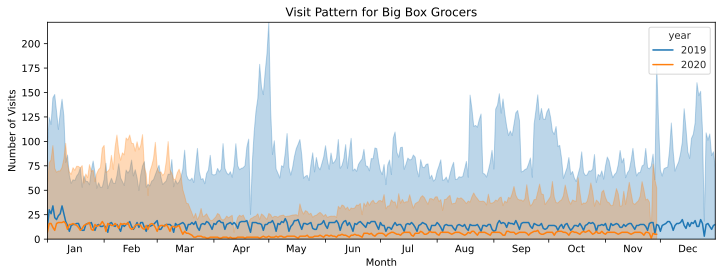

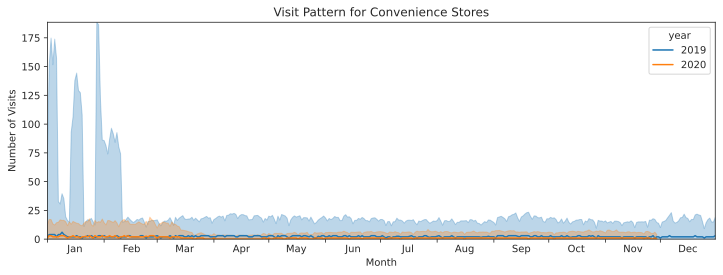

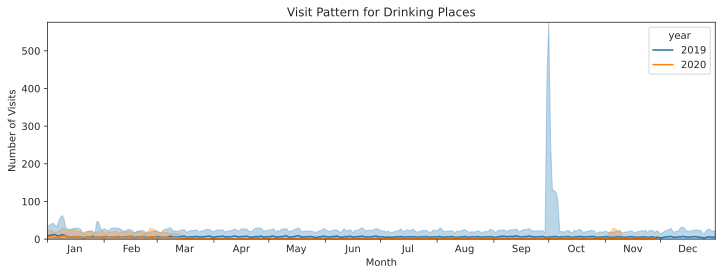

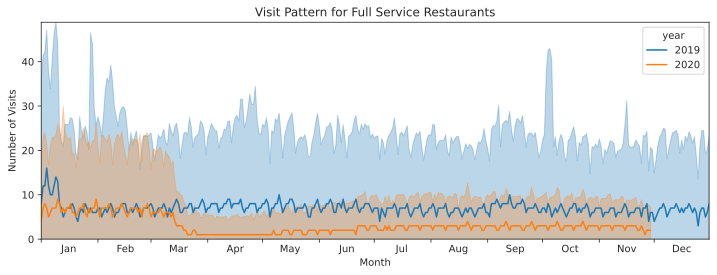

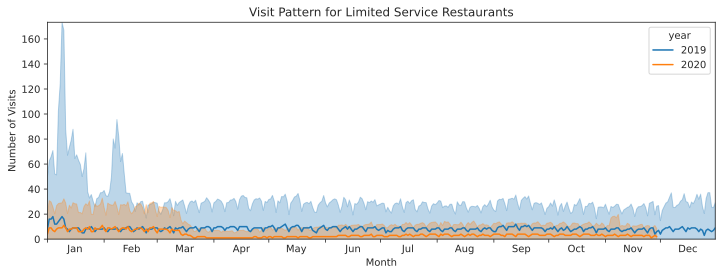

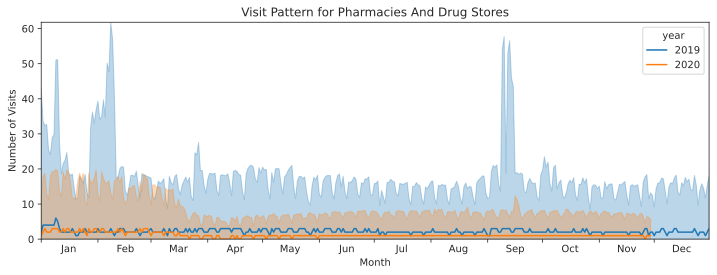

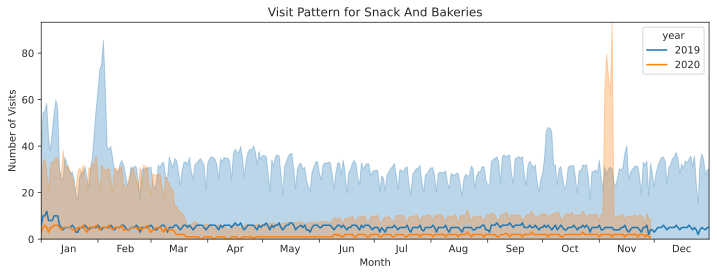

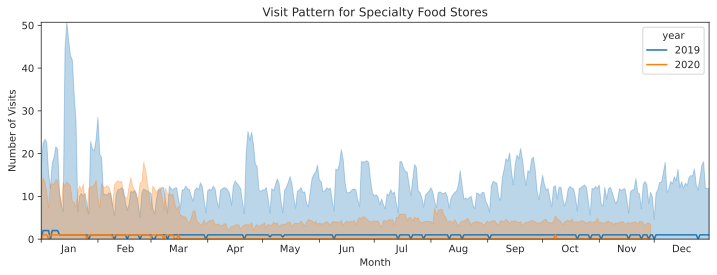

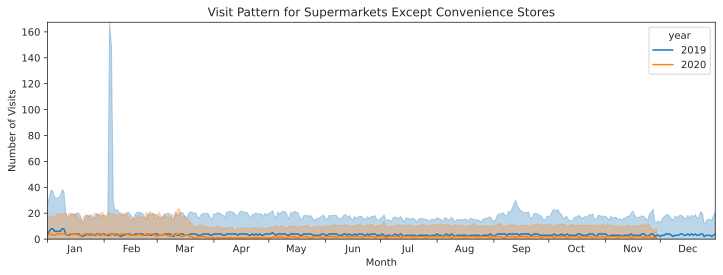

In [3]:
for fn in ('big_box_grocers.csv',
           'convenience_stores.csv',
           'drinking_places.csv',
           'full_service_restaurants.csv',
           'limited_service_restaurants.csv',
           'pharmacies_and_drug_stores.csv',
           'snack_and_bakeries.csv',
           'specialty_food_stores.csv',
           'supermarkets_except_convenience_stores.csv'):
    title = fn[:-4].replace('_', ' ').title()
    linePlot(fn, title=f'Visit Pattern for {title}')